In [2]:
from optimize import optimize
from signals import compute_features, detect_trade_signals
from backtester import Backtester

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [3]:
## commodity prices ##
commodities = pd.read_csv('../Data/raw/commodity_prices.csv',index_col=['Date'])
commodities.index = pd.to_datetime(commodities.index)

## stock prices ##
stocks = pd.read_csv('../Data/raw/stock_prices.csv',index_col=['Date'])
stocks.index = pd.to_datetime(stocks.index)

### Test optimizer

In [46]:
# Example pair
commodity = commodities['GC=F Close']
stock = stocks['STX']

param_grid = {
    'threshold': np.linspace(0,0.99,20),
    'streak': [2, 3, 4],
    'quantile': np.linspace(0,0.99,20),
    'lag': [1,2,3]
}

results = optimize(commodity, stock, param_grid)
print(results.head(10))

     threshold  streak  quantile  final_return  lag
3     0.000000       2  0.052105      1.666954    1
63    0.000000       3  0.052105      1.590389    1
6     0.000000       2  0.104211      1.576093    1
183   0.052105       2  0.052105      1.555611    1
243   0.052105       3  0.052105      1.541841    1
123   0.000000       4  0.052105      1.520441    1
66    0.000000       3  0.104211      1.478090    1
258   0.052105       3  0.312632      1.468932    1
303   0.052105       4  0.052105      1.445881    1
180   0.052105       2  0.000000      1.434790    1


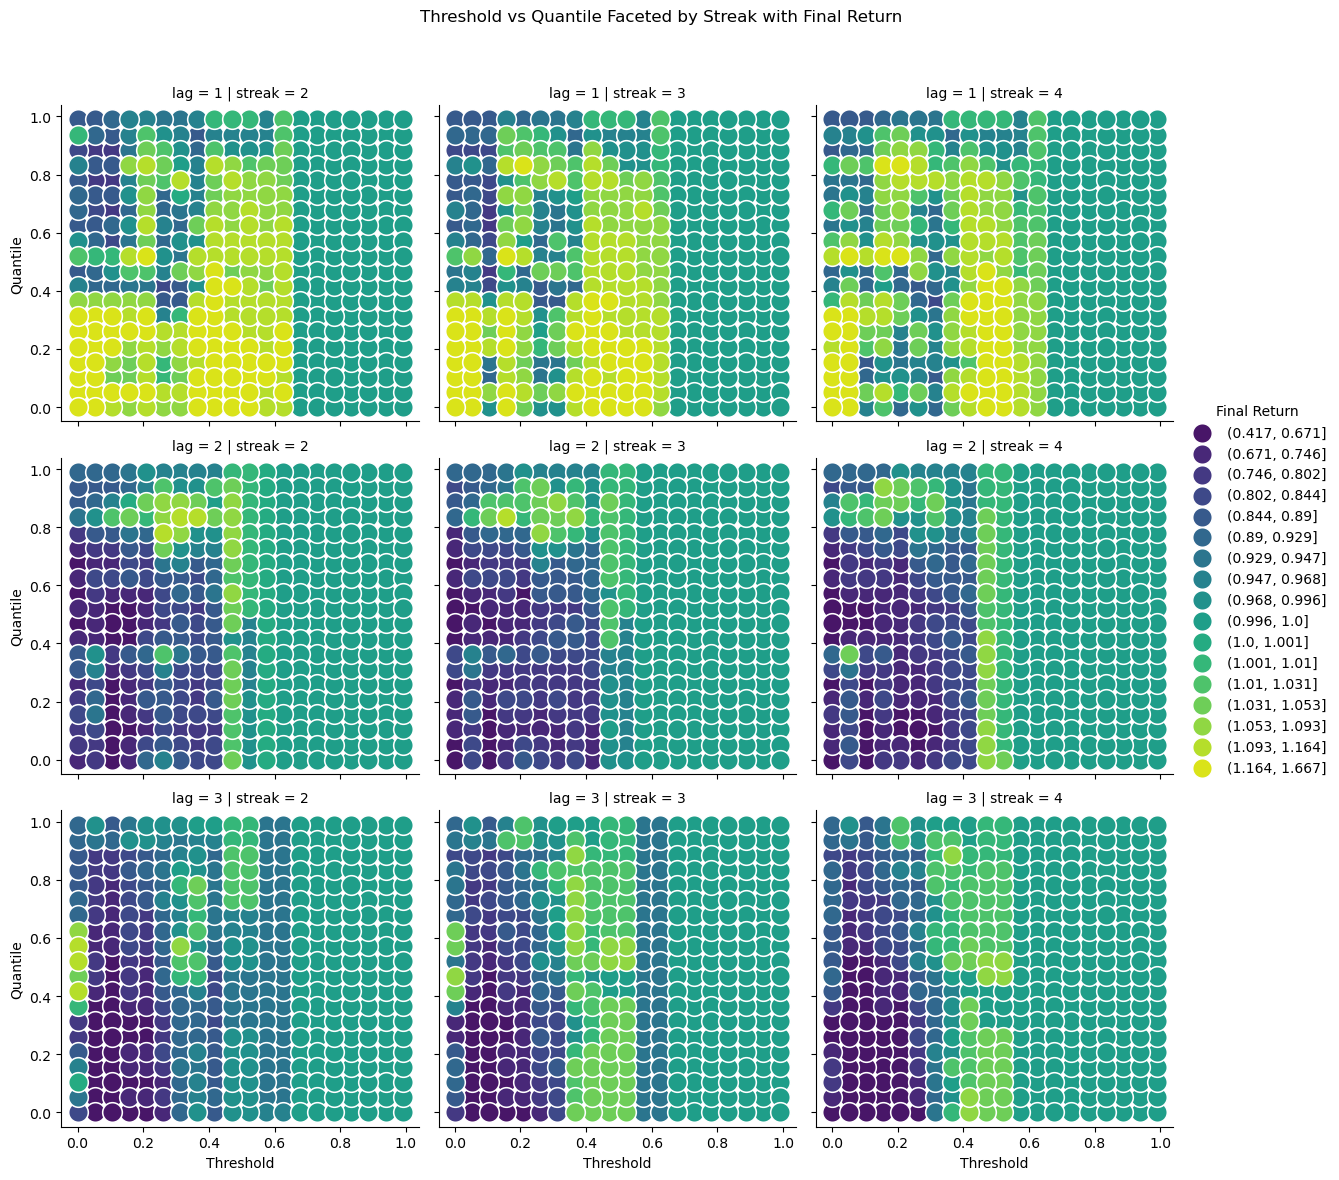

In [67]:
vmin = results['final_return'].min()
vmax = results['final_return'].max()
results['return_bin'] = pd.qcut(results['final_return'], q=25, duplicates='drop')

g = sns.FacetGrid(
    results, 
    col='streak',
    row='lag', 
    height=4, 
    sharex=True, 
    sharey=True,
    hue='return_bin',
    palette='viridis'   
)

g.map_dataframe(
    sns.scatterplot,
    x='threshold',
    y='quantile',
    size=None,
    s=200 
)


g.add_legend(title='Final Return')
g.set_axis_labels('Threshold', 'Quantile')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Threshold vs Quantile Faceted by Streak with Final Return')

plt.show()

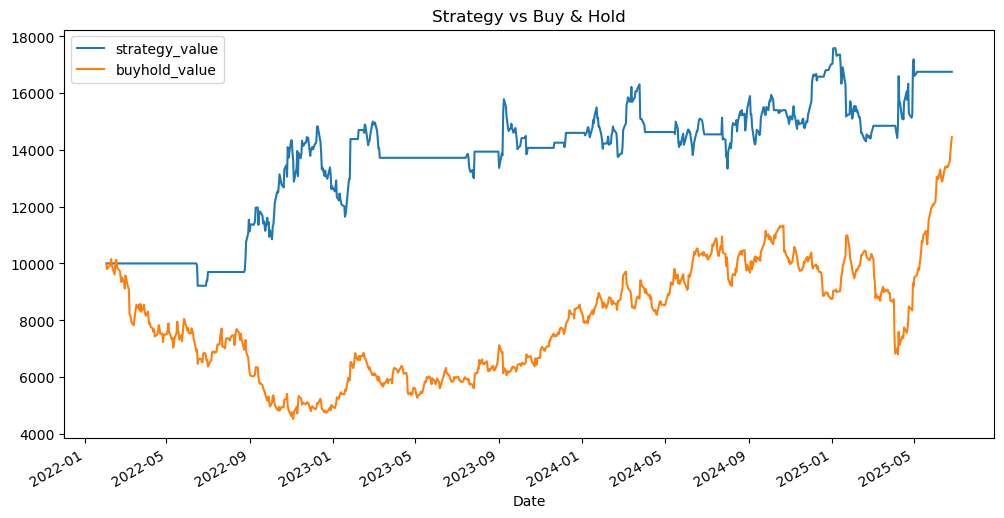

In [68]:
i = 0

threshold = results.iloc[i,:]['threshold']
min_streak = results.iloc[i,:]['streak']
quantile = results.iloc[i,:]['quantile']
lag = results.iloc[i,:]['lag']


features_df = compute_features(commodity,stock,lag)
features_df['stock_price'] = stock
signals_df = detect_trade_signals(
    features_df, 
    threshold=threshold, 
    min_streak=min_streak, 
    quantile=quantile)

bt = Backtester(
    prices = features_df,
    signals = signals_df,
    stock_col = 'stock_price',
    starting_capital = 10_000
)

result = bt.run()

# Visualize
result[['strategy_value', 'buyhold_value']].plot(
    figsize=(12,6), title='Strategy vs Buy & Hold'
)

plt.show()
